<a href="https://colab.research.google.com/github/LevPerla/Deep_Learning_school/blob/master/homework_simpsons_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка правильной версии Pillow

In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'5.3.0'

In [0]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---

### Установка зависимостей

In [3]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)


In [0]:
# https://download.pytorch.org/whl/torch_stable.html 
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# Для воспроизводимости результата фиксируем зерно датчиков случайных чисел
import random
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [0]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [9]:
!ls train

simpsons_dataset


In [10]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed May 13 18:56:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Скачивание данных

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px 
# установить 299 для inception
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # Также добавил разные аугментации, чтобы увеличить размер датасета
        # причем применяю их только для train, чтобы не исказить картинки для проверки
        if self.mode == "train":
          transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(20), 
                transforms.ColorJitter(hue=(-0.001,0.05)),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else:
          transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
# создаем списки с названиями картинок
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
# разделяем на train и validation
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

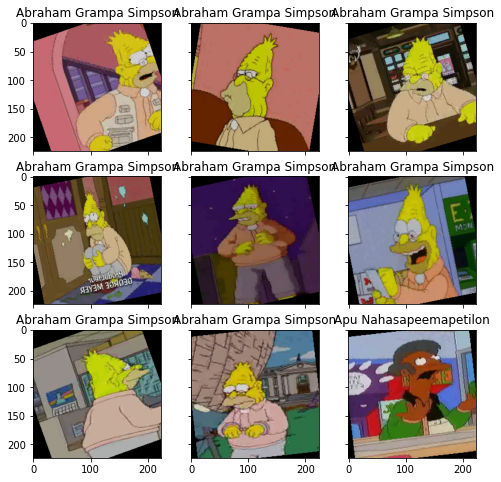

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,
           plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Определение классов и функций

In [0]:
# Очень простая сеть. Не использовал, но пусть будет как пример.
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size, path_to_checkpoint=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        # Попробовал несколько оптимизаторов. Отсановился на AdamW
        # optimizer = torch.optim.Adam(model.parameters())
        # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)
        loss = nn.CrossEntropyLoss()
        epoch = 0
        
        # Написал отдельный блок, если хотим восстановить с чекпоинта для дальнейшего обучения
        if path_to_checkpoint is not None:
          checkpoint = torch.load(path_to_checkpoint)
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          epoch = checkpoint['epoch']
          loss = checkpoint['loss']

        for epoch in range(epoch, epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # После окончания каждой эпохи сохраняем чекпоинт, чтобы не терять веса, если на следующих эпохах
            # модель начнет переобучаться, либо GC выключит ядро
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss},"/content/gdrive/My Drive/model_weights_epoch№%s.pth" %(epoch + 1)) 
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
# Функции взял из комментариев к заданию. Полезно, чтобы отслеживать в каких именно классах ошибается модель

import itertools
from sklearn.metrics import confusion_matrix
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(n_classes))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

### Тренировка модели

In [0]:
# Определяем сколько классов в train
n_classes = len(np.unique(train_val_labels))

In [0]:
# Если бы хотели использовать модель simple_cnn

# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
# print("we will classify :{}".format(n_classes))
# print(simple_cnn)

In [35]:
# Для решения задачи решил попробовать использовать метод Finetuning для моделей resnet152,
# inception_v3 и vgg16.
# Лучше всего себя показала vgg16, поэтому ее и оставил как итоговое решение

%%time
# model = models.resnet152(pretrained=True)

# model = models.inception_v3(pretrained=True)
# model.aux_logits=False

model = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
# num_features = 2048
num_features = 25088 # для wgg16

# Заменяем Fully-Connected слой на наш линейный классификатор
# Cпециально расширил данную часть, чтобы не было резкого скачка с достаточно большого выхода
# поседнего сверточного слоя до 42 итоговых классов 
new_dence = nn.Sequential(nn.Linear(num_features, 1024),
                            nn.BatchNorm1d(1024),
                            nn.ReLU(),
                            nn.Linear(1024, 512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(),
                            nn.Linear(512, 256),
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Linear(256, n_classes))
# model.fc = new_dence
model.classifier = new_dence #для wgg16

# Использовать ли GPU
model = model.cuda()

CPU times: user 1.32 s, sys: 554 ms, total: 1.87 s
Wall time: 1.88 s


Запустим обучение сети.

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [0]:
# Если необходимо продолжить обучение, то можно разкомментировать 3 строку данной клетки
# и указать путь к последнему чекпоинту
%%time
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=32)
                # path_to_checkpoint="/content/gdrive/My Drive/model_weights_epoch№10.pth")

Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

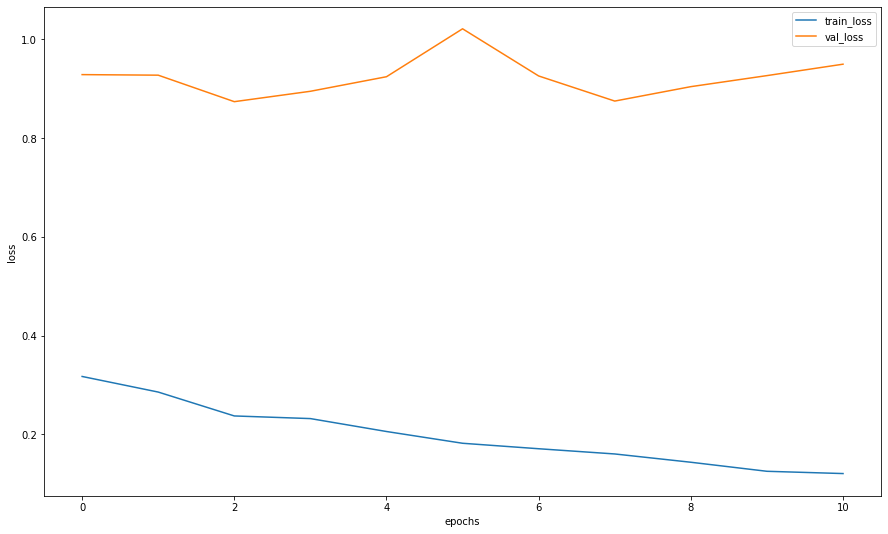

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

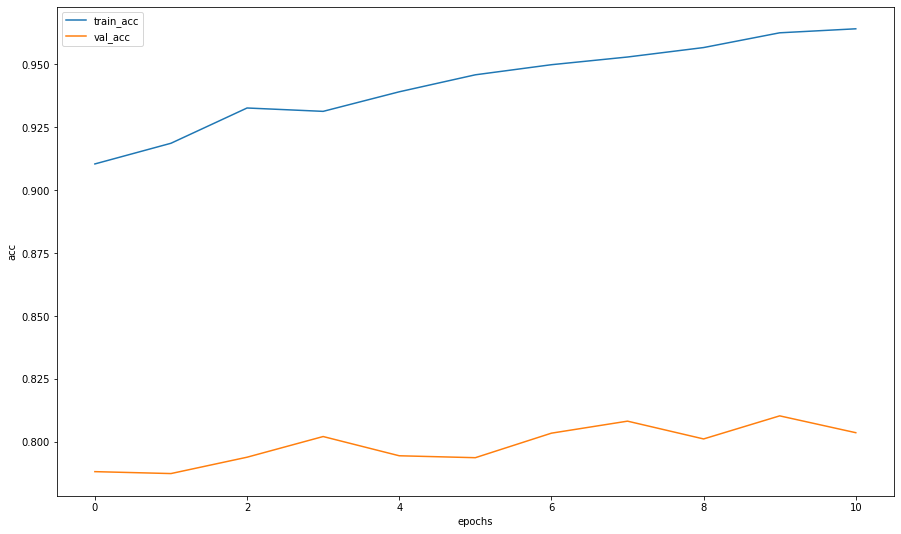

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Расчет качества прогноза на val

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [40]:
# загружаем сохраненное состояние весов нейросети, если вдруг отключилось ядро GC
# checkpoint = torch.load("/content/gdrive/My Drive/wgg16_2/model_weights_epoch№19.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику на валидационной выборке.

In [44]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="weighted")

0.9264501661129567

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

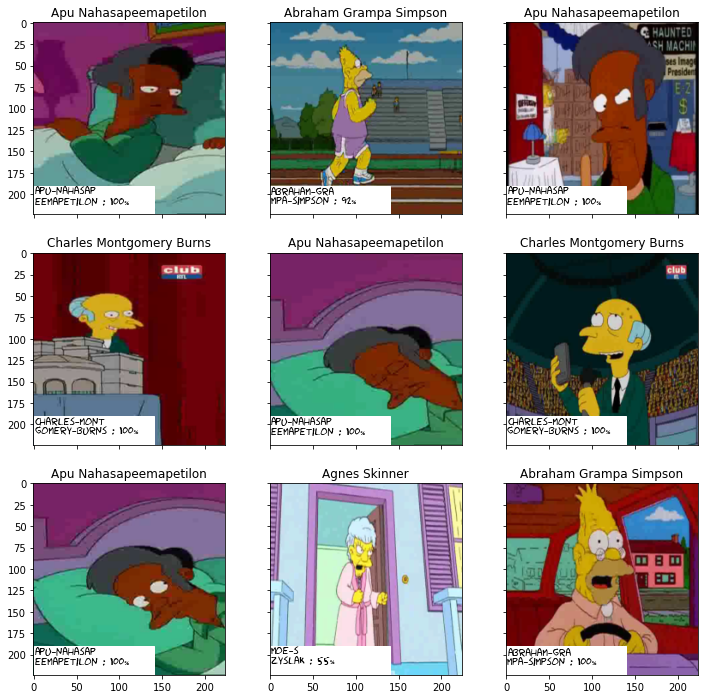

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 190),140,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")

    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))

    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 190, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')

Посмотрим какие классы сеть предсказывает плохо

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix
[229, 11, 146, 27, 350, 29, 317, 223, 9, 110, 2, 94, 6, 5, 40, 529, 130, 364, 67, 0, 327, 30, 302, 12, 62, 279, 4, 365, 386, 81, 9, 13, 340, 15, 5, 19, 31, 208, 5, 13, 1, 39]
42
Accuracy of abraham_grampa_simpson : 93 %
Accuracy of agnes_skinner : 72 %
Accuracy of apu_nahasapeemapetilon : 97 %
Accuracy of barney_gumble : 77 %
Accuracy of bart_simpson : 89 %
Accuracy of carl_carlson : 72 %
Accuracy of charles_montgomery_burns : 88 %
Accuracy of chief_wiggum : 97 %
Accuracy of cletus_spuckler : 88 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 100 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 80 %
Accuracy of groundskeeper_willie : 70 %
Accuracy of homer_simpson : 93 %
Accuracy of kent_brockman : 93 %
Accuracy of krusty_the_clown : 80 %
Accuracy of lenny_leonard : 95 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 96 %
Accuracy of maggie_simpson : 96 %
Accuracy of marge_simpson : 97 %
Accuracy of

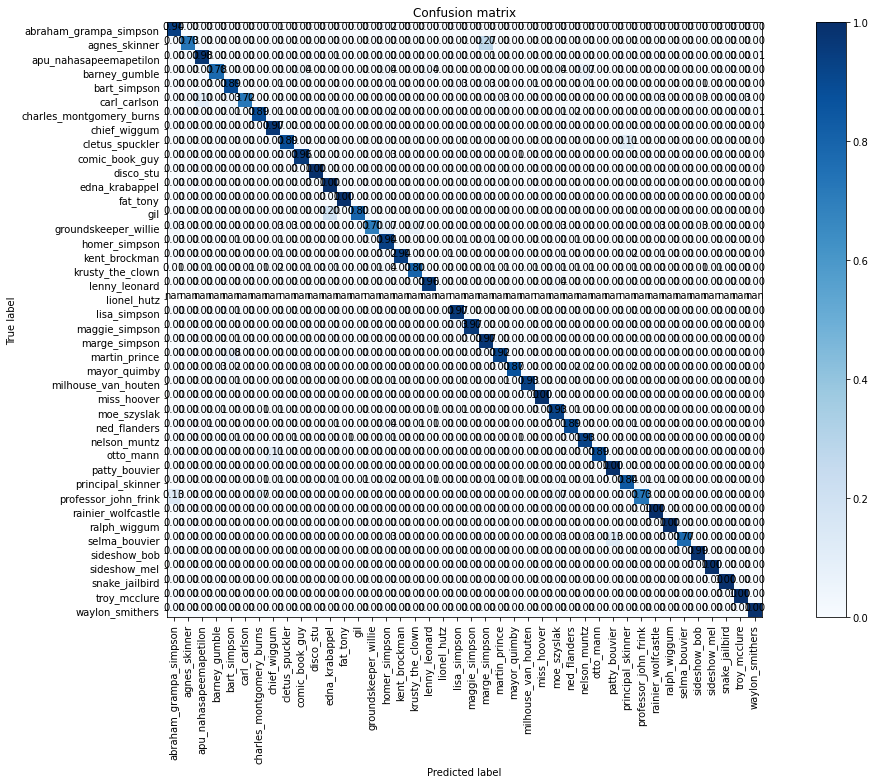

In [46]:
BATCH_SIZE = 32
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(model)

# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all)

### Предсказание на test и создание файла с результатами

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [48]:
# Создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds

name_of_model = str(input())
df.to_csv('/content/gdrive/My Drive/simpsons_%s.csv' % (name_of_model), index=False)

wgg16
